## Initialisation

### Dependencies

#### Third party

In [1]:
import os
import pandas as pd
import numpy as np
import inquirer
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from scipy import integrate
from matplotlib.widgets import Slider

#### Personal notebook

An index file already exists for AA 2195 T8. Do you want to re-initalise? (Y/n): 
An index file already exists for AA 2195 Solutionized. Do you want to re-initalise? (Y/n): 
An output file already exists for AA 2195 T8. Do you want to re-initalise? (Y/n): 
An output file already exists for AA 2195 Solutionized. Do you want to re-initalise? (Y/n): 


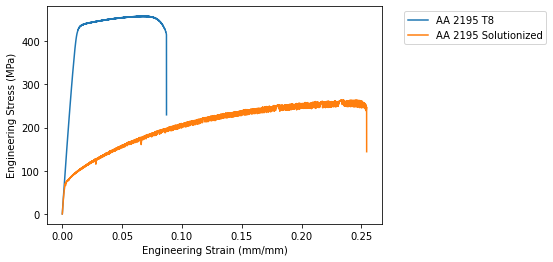

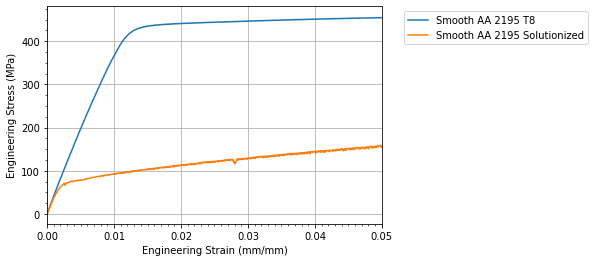

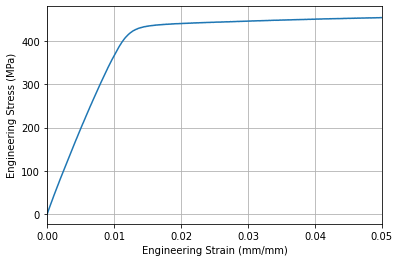

Enter the value of engineering strain upto which the line seems linear (used in calculation of Youngs modulus) in the units same as in AA 2195 T8's dataset: 0.012
Enter the value of engineering stress upto which the line seems linear (used in calculation of Youngs modulus) in the units same as in dataset: 412
Young's Modulus: 35.37699024475751 GPa


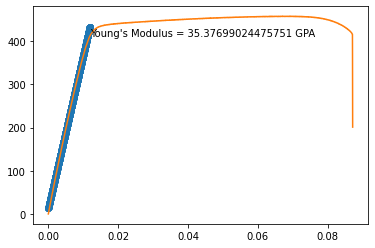

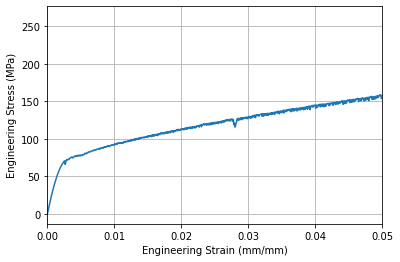

Enter the value of engineering strain upto which the line seems linear (used in calculation of Youngs modulus) in the units same as in AA 2195 Solutionized's dataset: 0.003
Enter the value of engineering stress upto which the line seems linear (used in calculation of Youngs modulus) in the units same as in dataset: 65
Young's Modulus: 30.979220593078484 GPa


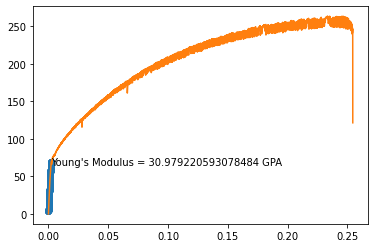

Yield Strength: 432.457854 MPa


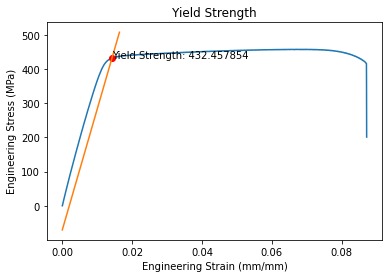

Yield Strength: 78.10249 MPa


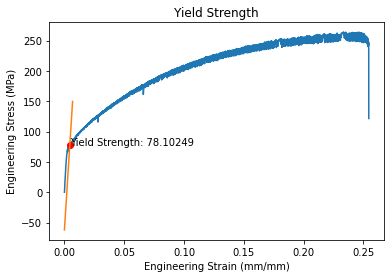

Ultimate Tensile Strength is 457.9231510000001 MPa at 6.798% elongation.
Ultimate Tensile Strength is 263.639546 MPa at 23.327% elongation.


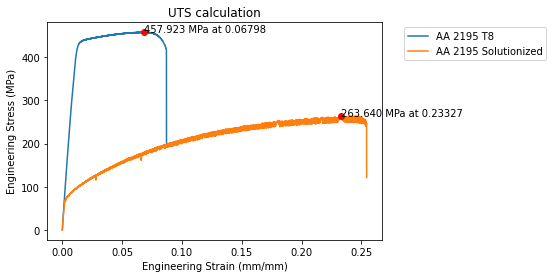

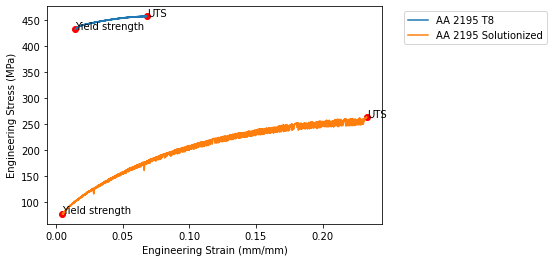

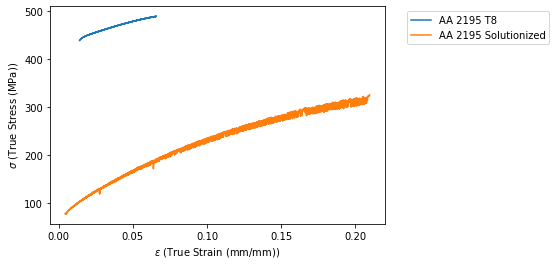

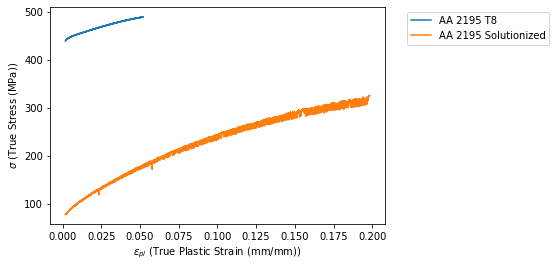

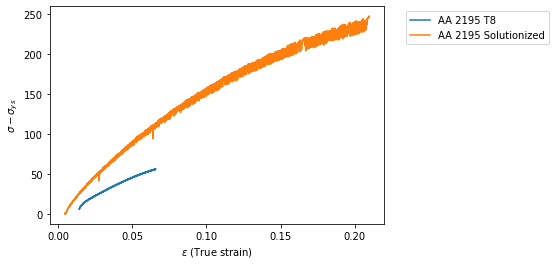

In [2]:
import ipynb

from ipynb.fs.full.dataset_initialisation import (
    ifile,
    ofile,
    OUTPUT_DIR,
    PROJECT_NAME,
)
from ipynb.fs.defs.utilities import (
    differentiate,
    dash,
)

true_plastic_strain = []
true_stress = []

for i in range(len(OUTPUT_DIR)):
    if (os.path.exists(f'{OUTPUT_DIR[i]}/true_plastic_strain_vs_true_stress.csv')):
        df = pd.read_csv(f'{OUTPUT_DIR[i]}/true_plastic_strain_vs_true_stress.csv', sep=',', names=['x','y'])
        true_plastic_strain.append(df['x'].to_numpy())
        true_stress.append(df['y'].to_numpy())
else:
    from ipynb.fs.full.true_strain_stress import (
        true_plastic_strain,
        true_stress,
    )

true_strain = []
flow_stress = []

for i in range(len(OUTPUT_DIR)):
    if (os.path.exists(f'{OUTPUT_DIR[i]}/true_strain_vs_flow_stress.csv')):
        df = pd.read_csv(f'{OUTPUT_DIR[i]}/true_strain_vs_flow_stress.csv', sep=',', names=['x','y'])
        true_strain.append(df['x'].to_numpy())
        flow_stress.append(df['y'].to_numpy())
else:
    from ipynb.fs.full.true_strain_stress import (
        true_strain,
        flow_stress,
    )

yield_strength = [i.get_parameter('yield_strength') for i in ifile]
if yield_strength is None:
    from ipynb.fs.full.engineering_strain_stress import (
        yield_strength,
    )

### Notations

- $\sigma \rightarrow$ True Stress
- $\epsilon \rightarrow$ True Strain
- $\epsilon_{pl} \rightarrow$ True Plastic Strain
- $\sigma_{ys} \rightarrow$ Yield Strength
- $\sigma_{uts} \rightarrow$ Ultimate Tensile Strength
- $n \rightarrow$ Work hardening Exponent
- $E \rightarrow$ Young's Modulus
- $K \rightarrow$ Strength Coefficient
- $e \rightarrow$ Engineering Strain
- $s \rightarrow$ Engineering Stress
- $\theta \rightarrow$ Work hardening rate
- $\sigma - \sigma_{ys} \rightarrow$ Flow Stress
- $\sigma_{s} \rightarrow$ Saturation stress
- $\theta \rightarrow$ Work hardening rate
- $\theta_{0} \rightarrow$ Initial work hardening rate
- $\sigma_{v} \rightarrow$ Scaling stress

## Voce equation

$$ \sigma = \sigma_{s} \left(1 - exp\left(\frac{\theta_{0}}{\sigma_{v}}\right) \epsilon_{pl} \right)  $$

$$ \sigma = \sigma_{s} \left(1 - exp\left(\frac{k_{2}}{2}\right) \epsilon_{pl} \right) \because \frac{\theta_{0}}{\sigma_{v}} = \frac{k_{2}}{2}$$

$ \therefore $ Therefore only two fitting parameters ($ k_{2} $ and $ \sigma_{s} $) are necessary to describe the work hardening behaviour at a given temperature.

$ A $ is $ \sigma_{s} $
$ \\ $
$ B $ is $ \frac{\theta_{0}}{\sigma_{v}} $

For our experiment, we are assuming that scaling stress = saturation stress.

### Initial work hardening rate

$ A $ is $ \sigma_{s} $
$ \\ $
$ B $ is $ \frac{\theta_{0}}{\sigma_{v}} $

$ B = \frac{\theta_{0}}{\sigma_{s}} \because \sigma_{v} = \sigma_{s} $

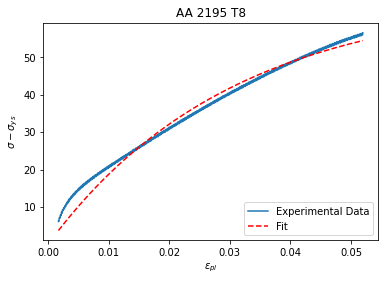

Saturation stress: 66.45264077265566 MPa
B: 33.06347258530547
k2: 66.12694517061094
Initial work hardening rate: 2197.1550664078527


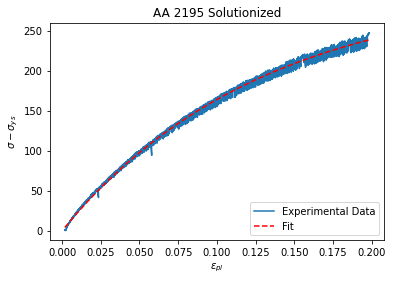

Saturation stress: 303.85298424423866 MPa
B: 7.779937619750158
k2: 15.559875239500316
Initial work hardening rate: 2363.9572629951044


In [3]:
def fit_voce(x, A, B): # A is saturation stress (sigma_s)
    return A*(1-np.exp(-B*x))

sigma_s = []
theta_0 = []

for i in range(len(true_plastic_strain)):
    rhs_theoretical_voce = curve_fit(
        fit_voce, true_plastic_strain[i], flow_stress[i], None, method='lm'
    )

    popt, _ = rhs_theoretical_voce
    sigma_s.append(popt[0])
    B = popt[1]

    fig, ax = plt.subplots(1,1)
    ax.plot(true_plastic_strain[i], flow_stress[i])
    ax.plot(true_plastic_strain[i], [fit_voce(pl, sigma_s[i], B) for pl in true_plastic_strain[i]], 'r--')
    ax.set_xlabel('$\\epsilon_{pl}$')
    ax.set_ylabel('$\sigma - \sigma_{ys}$')
    ax.set_title(PROJECT_NAME[i])

    ax.legend(['Experimental Data','Fit'], loc='lower right')

    fig.savefig(f'{OUTPUT_DIR[i]}/Voce hardening equation', facecolor='white', transparent=True)
    plt.show()

    print(f'Saturation stress: {sigma_s[i]} MPa')
    print(f'B: {B}')
    print(f'k2: {2*B}')

    if ifile[i].add_parameter('sigma_s', sigma_s[i]):
        ofile[i].save_parameter('Saturation stress', sigma_s[i], 'MPa')

    if ifile[i].add_parameter('k2', 2*B):
        ofile[i].save_parameter('k2 (Kocks mecking model)', 2*B, 'MPa')
        
    theta_0.append(B*sigma_s[i])

    print(f'Initial work hardening rate: {theta_0[i]}')

    if ifile[i].add_parameter('theta_0', theta_0[i]):
        ofile[i].save_parameter('Initial work hardening rate', theta_0[i], 'MPa')

## Constants of Kocks-Mecking model

$$ \theta_{0} = \frac{\alpha\mu bMk_{1}}{2} $$
$$ \sigma_{v} = \frac{\alpha\mu bMk_{1}}{k_{2}} $$

$$ k_{1} = \frac{2\theta_{0}}{\alpha\mu bM} $$
$$ k_{2} = \frac{2\theta_{0}}{\sigma_{v}} $$

## Material constants

In [4]:
alpha = 0.3
burger_vector_mag = 2.86e-10 # m
shear_modulus = 27e3
taylor_factor = 3 # assuming random texture

In [5]:
k1_kocks = []
k2_kocks = []

for i in range(len(theta_0)):
    k1_kocks.append((2*theta_0[i])/(alpha*shear_modulus*burger_vector_mag*taylor_factor))
    k2_kocks.append((2*theta_0[i])/sigma_s[i])

    print(dash(PROJECT_NAME[i]))
    print(f'k1: {k1_kocks[i]}')
    print(f'k2: {k2_kocks[i]}')

    if ifile[i].add_parameter('k1', k1_kocks[i]):
        ofile[i].save_parameter('k1 (Kocks mecking model)', k1_kocks[i], 'm^-1')

--------------------AA 2195 T8--------------------
k1: 632293034.7370723
k2: 66.12694517061094
---------------AA 2195 Solutionized---------------
k1: 680295048.2014172
k2: 15.559875239500316


$$ \rho = \left(\frac{k1}{k2}\right)^2 \left(1-exp(\frac{-k_{2}\epsilon_{pl}}{2})\right)^2 $$

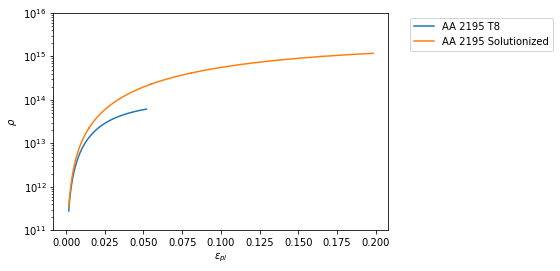

In [6]:
fig, ax = plt.subplots(1,1)

for i in range(len(true_plastic_strain)):

    dislocation_density = [((k1_kocks[i]/k2_kocks[i])**2) * ((1-np.exp((-k2_kocks[i]*pl)/2))**2) for pl in true_plastic_strain[i]]

    ax.plot(true_plastic_strain[i], dislocation_density)
    ax.set_yscale('log')
    ax.set_ylim(1e11, 1e16)
    ax.set_xlabel('$\epsilon_{pl}$')
    ax.set_ylabel('$\\rho$')

    plt.savefig(f'{OUTPUT_DIR[i]}/True plastic strain vs dislocation density', facecolor='white', transparent=False)

    pd.DataFrame(
        np.transpose(np.asarray([true_plastic_strain[i], dislocation_density], dtype=object))
    ).to_csv(f'{OUTPUT_DIR[i]}/true_plastic_strain_vs_dislocation_density.csv', index=False, header=False)
    
_ = ax.legend(PROJECT_NAME, loc='upper left', bbox_to_anchor=(1.05, 1))

## Verifying value of $ \rho_{s} $

$\rho_{s}$ can be calculated in 2 ways.

#### Kocks mecking model
$$ \frac{d\sigma}{d\epsilon} = k_{1}\sqrt \rho - k_{2}\rho $$

At saturation stress, $ \frac{d\sigma}{d\epsilon} = 0$

$$ k_{1}\sqrt \rho_{rs} = k_{2}\rho_{s} $$

$$ \rho_{s} = \left(\frac{k_{1}}{k_{2}}\right)^2 $$

#### Taylor equation
$$ \sigma = \alpha\mu bM \sqrt \rho  $$

$$ \rho_{s} = \left(\frac{\sigma_{s}}{\alpha\mu bM} \right)^2 $$

# Geometric obstacle

$$ \frac{d\rho}{d\epsilon_{pl}} = M \left(k - k_{2}\rho \right)$$

$$ k = \frac{1}{bd} $$

where; <br />
$ d $ is spacing between the grains.

Solving the differential equation results in:

$$ \sigma = \alpha M\mu b \sqrt{\left(\frac{k}{k_{2}}\right)}\sqrt{\left(1 - e^{-M\epsilon_{pl}k_{2}}\right)} $$

Reference: G. A. Malygin, *Analysis of Structural Factors That Control Necking during Tension of FCC Metals and Alloys*, Physics of the Solid State, Vol. 47, No. 2, 2005, Page 247 Equation 5

In [7]:
%matplotlib widget

def fit_geo (x, A, B):
    sigma_m = taylor_factor*alpha*shear_modulus*burger_vector_mag*np.sqrt(A/B)
    return sigma_m*np.sqrt(1-np.exp(-taylor_factor*B*x))


i = int(input(f'Select project {",".join([i for i in PROJECT_NAME])} ({",".join([str(i) for i in range(len(PROJECT_NAME))])}): '))

guess_k_geo = float(input('Enter the initial guess of k for geometric model: '))
guess_k2_geo = float(input('Enter the initial guess of k2 for geometric model: '))

fig, ax = plt.subplots(1,1)
plt.subplots_adjust(left=0.25, bottom=0.25)

ax.plot(true_plastic_strain[i], flow_stress[i])
ax.plot(true_plastic_strain[i], [fit_geo(pl,guess_k2_geo, guess_k_geo) for pl in true_plastic_strain[i]], 'r--')
ax.set_xlabel('$\\epsilon_{pl}$')
ax.set_ylabel('$\sigma - \sigma_{ys}$')
ax.set_title(PROJECT_NAME[i])
ax.legend(['Experimental Data','Fit'], loc='lower right')

axk_geo = plt.axes([0.2, 0, 0.65, 0.03])
k_slider_geo = Slider(
    ax=axk_geo,
    label='k',
    valmin=1e14,
    valmax=1e15,
    valinit=guess_k_geo,
)
axk2_geo = plt.axes([0.2, 0.1, 0.65, 0.03])
k2_slider_geo = Slider(
    ax=axk2_geo,
    label='k2',
    valmin=0,
    valmax=30,
    valinit=guess_k2_geo,
)

def sliders_on_changed(val):
    ax.clear()
    _ = ax.plot(true_plastic_strain[i], flow_stress[i], 'r-')

    _ = ax.plot(true_plastic_strain[i], [fit_geo(pl, k_slider_geo.val, k2_slider_geo.val) for pl in true_plastic_strain[i]], 'blue')
    theoretical_geo = curve_fit(
        fit_geo, true_plastic_strain[i], flow_stress[i], [k_slider_geo.val, k2_slider_geo.val],
    )
    popt, _ = theoretical_geo
    ax.plot(true_plastic_strain[i], [fit_geo(pl, popt[0], popt[1]) for pl in true_plastic_strain[i]], 'green')
    ax.legend(['Experimental Data','Guess', 'Fit'], loc='lower right')
    ax.set_title(PROJECT_NAME[i])

k_slider_geo.on_changed(sliders_on_changed)
k2_slider_geo.on_changed(sliders_on_changed)

Select project AA 2195 T8,AA 2195 Solutionized (0,1): 0
Enter the initial guess of k for geometric model: 1e14
Enter the initial guess of k2 for geometric model: 5


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

0

## Hybrid model

$$ \frac{d\rho}{d\epsilon_{pl}} = M \left(k +  k_{1}\sqrt\rho - k_{2}\rho \right)$$

$$ \frac{d\sigma}{d\epsilon_{pl}} = \frac{M^2\alpha\mu b}{2} \left(k\frac{\alpha\mu bM}{\sigma} +  k_{1} - k_{2}\frac{\sigma}{\alpha\mu bM} \right)$$


$$ k = \frac{1}{bd} $$

where; <br />
$ d $ is spacing between the grains.

Solving the differential equation results in:

$$ \epsilon_{pl} = -\frac{log(k_{1}\sqrt\rho - k_{2}\rho + k) + \frac{2k_{1}tanh^{-1}\left(\frac{k_{1} - 2k_{2}\sqrt\rho}{\sqrt{k_{1}^2 + 4kk_{2}}} \right)}{\sqrt{k_{1}^2 + 4kk_{2}}}}{k_{2}M} + C$$

Since the differential equation cannot be expressed in terms of $\sigma$, we use Runge-Kutta method for numerical integration. 

Reference: G. A. Malygin, *Analysis of Structural Factors That Control Necking during Tension of FCC Metals and Alloys*, Physics of the Solid State, Vol. 47, No. 2, 2005, Page 247 Equation 5

In [8]:
initial_pl_strain = true_plastic_strain[0]

%matplotlib widget

def deqn(x, k, k1, k2):
    c = alpha*shear_modulus*burger_vector_mag*taylor_factor
    return taylor_factor*c/2*(k*c/x + k1 - k2*x/c)
    

def RK4(y0, iterations, k=1e14, k1=3e7, k2=1.2, h=0.00002):
    result = []
    yi = y0
    result.append(yi)
    for i in range(iterations):
        a1 = deqn(yi, k, k1, k2)
        a2 = deqn(a1/2*h + yi, k, k1, k2)
        a3 = deqn(a2/2*h + yi, k, k1, k2)
        a4 = deqn(a3*h + yi, k, k1, k2)
        yi = yi + 1/6*h*(a1+2*a2+2*a3+a4)
        result.append(yi)
    return result

i = int(input(f'Select project {",".join([i for i in PROJECT_NAME])} ({",".join([str(i) for i in range(len(PROJECT_NAME))])}): '))

fig, ax = plt.subplots(1,1)
plt.subplots_adjust(left=0.25, bottom=0.25)
_ = ax.plot(true_plastic_strain[i], flow_stress[i], 'ro')
_ = ax.plot(true_plastic_strain[i], RK4(flow_stress[i][0], len(flow_stress[i])-1))

_ = ax.legend(['Experimental Data','Fit'], loc='lower right')

axk_hybrid = plt.axes([0.25, 0, 0.65, 0.03])
k_slider_hybrid = Slider(
    ax=axk_hybrid,
    label='k',
    valmin=1e10,
    valmax=1e20,
    valinit=1e14,
)
axk1_hybrid = plt.axes([0.25, 0.05, 0.65, 0.03])
k1_slider_hybrid = Slider(
    ax=axk1_hybrid,
    label='k1',
    valmin=1e5,
    valmax=1e15,
    valinit=3e7,
)
axk2_hybrid = plt.axes([0.25, 0.1, 0.65, 0.03])
k2_slider_hybrid = Slider(
    ax=axk2_hybrid,
    label='k2',
    valmin=1,
    valmax=20,
    valinit=1.2,
)

def sliders_on_changed(val):
    ax.clear()
    ax.plot(true_plastic_strain[i], flow_stress[i], 'ro')
    ax.plot(true_plastic_strain[i], RK4(flow_stress[i][0], len(flow_stress[i])-1, k_slider_hybrid.val, k1_slider_hybrid.val, k2_slider_hybrid.val))
    ax.legend(['Experimental Data','Fit'], loc='lower right')

k_slider_hybrid.on_changed(sliders_on_changed)
k1_slider_hybrid.on_changed(sliders_on_changed)
k2_slider_hybrid.on_changed(sliders_on_changed)

Select project AA 2195 T8,AA 2195 Solutionized (0,1): 1


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

0